In [6]:
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.time import Time
import astropy.units as u
from astropy.visualization import time_support

import photutils

from fass.ser import load_ser_file
from fass.analyze_cube import find_apertures, moments, seeing, analyze_dimm_cube

time_support(simplify=True)

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x12d3a6860>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
plt.close('all')

In [8]:
testfile = Path.home() / "MMT/FASS/data/indi_2022-08-29/indi_record_2022-08-29@05-48-58.ser"
d = load_ser_file(testfile)

/Users/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [19]:
testfile = Path.home() / "MMT/FASS/data/indi_2022-08-29/indi_record_2022-08-29@05-48-58.ser"
ave_seeing, seeing_vals, baselines, apertures, frame_times, fig = analyze_dimm_cube(testfile, plot=False)
ave_seeing

/Users/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


<Quantity 1.97876568 arcsec>

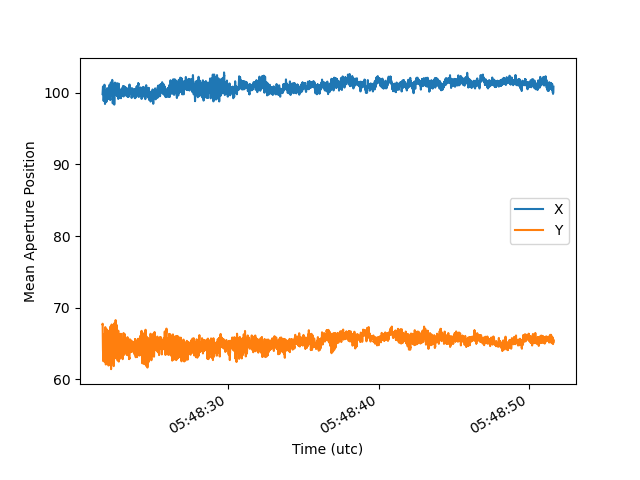

In [20]:
fig, ax = plt.subplots()
ax.plot(frame_times, apertures[0], label='X')
ax.plot(frame_times, apertures[1], label='Y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Mean Aperture Position")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

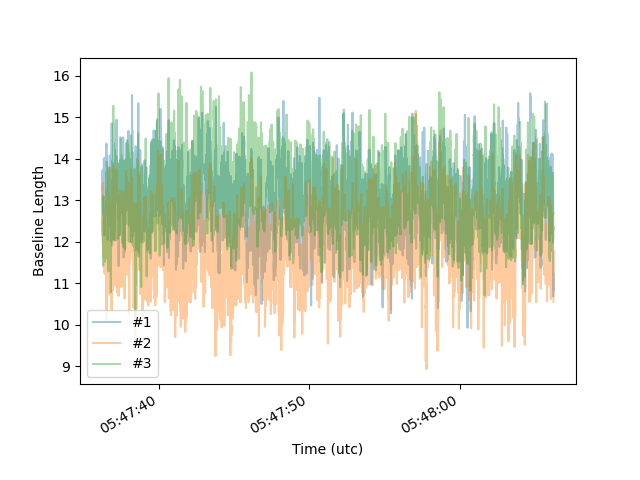

In [14]:
fig, ax = plt.subplots()
ax.plot(frame_times, baselines[0], label='#1', alpha=0.4)
ax.plot(frame_times, baselines[1], label='#2', alpha=0.4)
ax.plot(frame_times, baselines[2], label='#3', alpha=0.4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Baseline Length")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

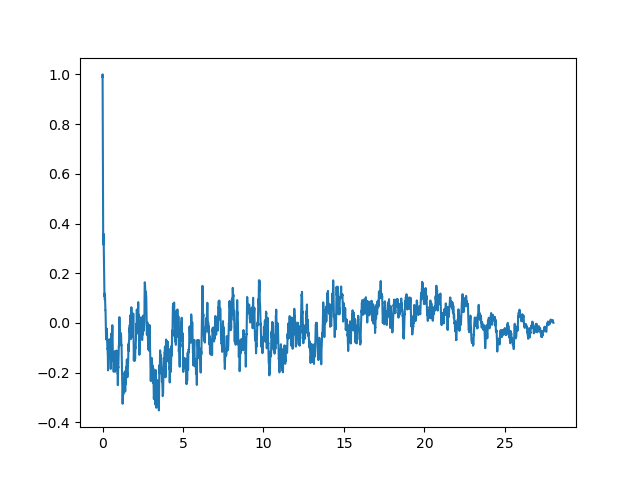

In [18]:
b0 = baselines[0] - baselines[0].mean()
b1 = baselines[1] - baselines[1].mean()
b2 = baselines[2] - baselines[2].mean()
dt = (frame_times[1] - frame_times[0]).to_value('sec')
autocor = np.correlate(b0, b2, mode='full')
autocor = autocor[autocor.size // 2 :]
fig = plt.figure()
plt.plot(dt * np.arange(autocor.size), autocor/autocor.max())
plt.show()